In [2]:
import warnings   
warnings.simplefilter("ignore") 
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib notebook
import sys
sys.path.append('/Users/Serene/calour')
import calour as cl
import numpy as np
import pandas as pd
import calour.cahelper as cah
import calour.analysis

from scipy.stats import sem
import pickle

In [3]:
cl.set_log_level(40) # get rid of warnings in calour

# Loads the data

In [7]:
sample_ = pd.read_csv('data/uk_twins_sample.txt', sep='\t', dtype=str)
prep_ = pd.read_csv('data/uk_twins_prep.txt', sep='\t', dtype=str)

In [8]:
sample_.set_index('sample_name', inplace=True)
prep_.set_index('sample_name', inplace=True)

map_ = pd.concat([sample_, prep_], axis=1)

# Filters the data for samples of interest.

We'll look at female twins with BMIs between 18.5 to 25 and 30 to 37.5. We want them from different families, and ideally mixed across shipments.

In [9]:
def map_bmi(x):
    x = float(x)
    if (18.5 <= x) & (x < 25):
        return 'Lean'
#     elif (25 <= x) & (x < 30):
#         return 'Overweight'
    elif (30 <= x) & (x < 37.5):
        return 'Obese'
    else:
        return np.nan
map_['bmi_cat'] = map_['body_mass_index'].apply(map_bmi)

In [10]:
def filter_map(x):  
    return not ((pd.isnull(x['zygosity'])) | 
                (pd.isnull(x['bmi_cat'])) | 
                (x['sex'] == 'male'))


twin_map = map_.loc[map_.apply(filter_map, axis=1)]  # only 'lean' and 'obese' groups, without 'NA' values

In [11]:
lean = []  # store all subject ids for 'lean' subjects
obese = [] # all subject ids for 'obese' subjects
for family, family_map in twin_map.groupby('familyid'):
    sample = np.random.choice(family_map.index, 1)[0]
    if family_map.loc[sample, 'bmi_cat'] == 'Lean':
        lean.append(sample)
    else:
        obese.append(sample)

In [12]:
ana_map = map_.loc[np.hstack((lean, obese))]

In [14]:
ana_map.to_csv('uk_twins_map.txt', sep='\t')

## use calour

In [4]:
ukt = cl.read_taxa('data/uk_twins_otu.biom','data/uk_twins_map.txt',sparse=False, filter_orig_reads=1000)

In [17]:
ukt.sample_metadata.bmi_cat.value_counts()

Lean     273
Obese    114
Name: bmi_cat, dtype: int64

In [71]:
ukt.diff_abundance('bmi_cat','Lean','Obese',fdr_method='dsfdr')

AmpliconExperiment uk_twins_otu.biom with 1017 samples, 329 features

In [5]:
np.random.seed(31)
ukt_sub1 = ukt.filter_min_abundance(5)

In [ ]:
def ds_gap(pvals, cdf):
    gap = []
    for i in range(len(pvals)):
        dist = pvals[i] - cdf[i]
        if dist > 0:
            gap.append(dist)
        if dist <= 0:
            gap.append(0)
    norm = np.sum(gap)
    return norm

In [72]:
xx=ukt_sub1.diff_abundance('bmi_cat','Lean','Obese', alpha = 1, fdr_method='dsfdr')

In [75]:
yy = xx.feature_metadata['_calour_diff_abundance_pval']

<IPython.core.display.Javascript object>


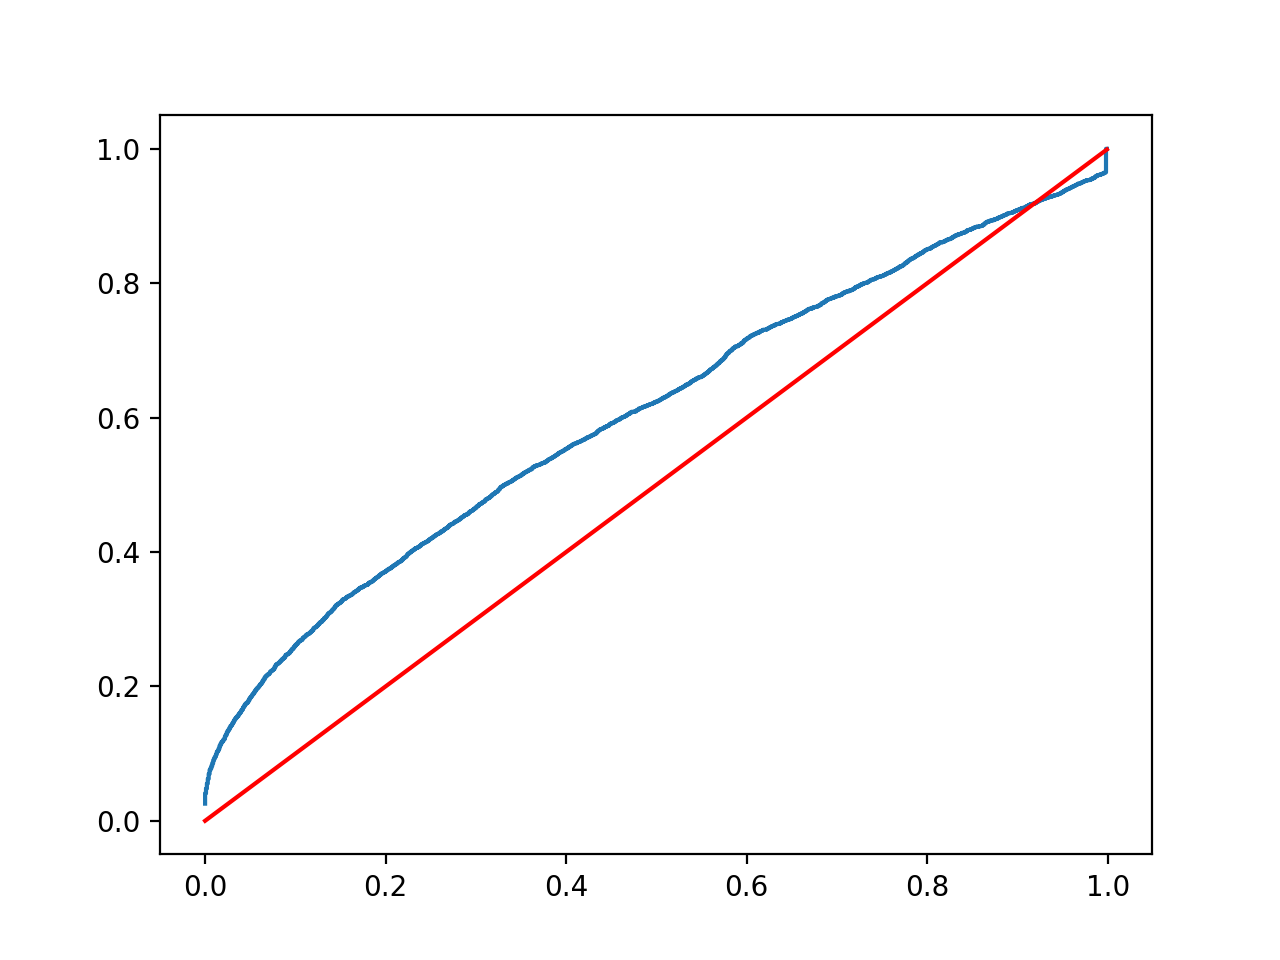

3.77014982443


In [86]:
from statsmodels.distributions.empirical_distribution import ECDF
from numpy import linalg as LA

sample = yy  
ecdf = ECDF(sample)

x = np.sort(sample)
y = ecdf(x)
plt.figure()
plt.step(x, y)
plt.plot(x, x, color = 'red')

gap = []
for i in range(len(x)):
    dist = x[i] - y[i]
    if dist > 0:
        gap.append(dist)
    if dist <= 0:
        gap.append(0)
norm = np.sum(gap)
print(norm)

In [80]:
a = ukt_sub3.diff_abundance('bmi_cat','Lean','Obese',alpha=1, fdr_method='dsfdr')
b = a.feature_metadata['_calour_diff_abundance_pval']

<IPython.core.display.Javascript object>


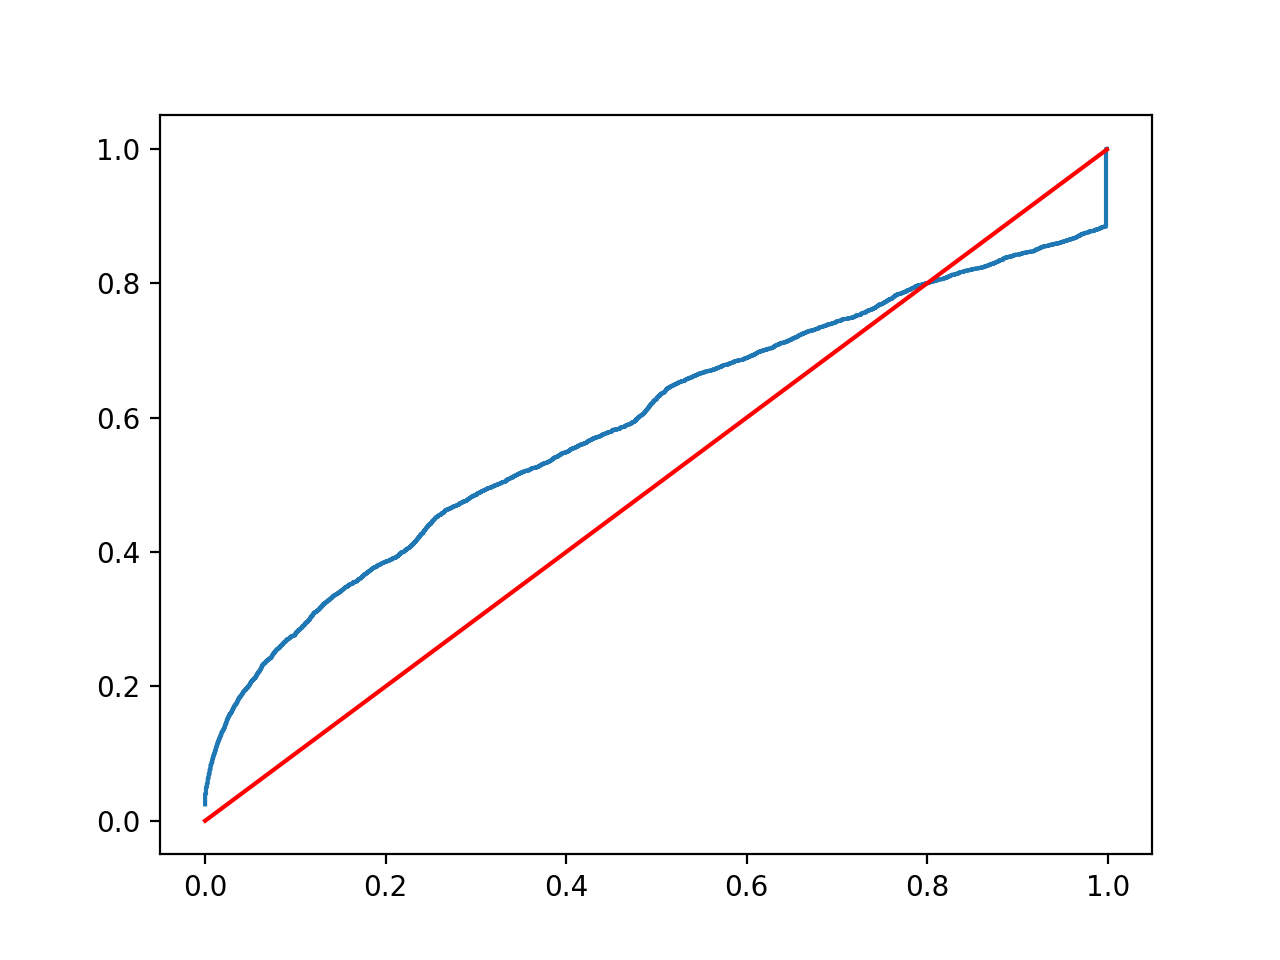

23.3280444079


In [85]:
sample = b 
ecdf = ECDF(sample)

x = np.sort(sample)
y = ecdf(x)
plt.figure()
plt.step(x, y)
plt.plot(x, x, color = 'red')

gap = []
for i in range(len(x)):
    dist = x[i] - y[i]
    if dist > 0:
        gap.append(dist)
    if dist <= 0:
        gap.append(0)
norm = np.sum(gap)
print(norm)

<IPython.core.display.Javascript object>


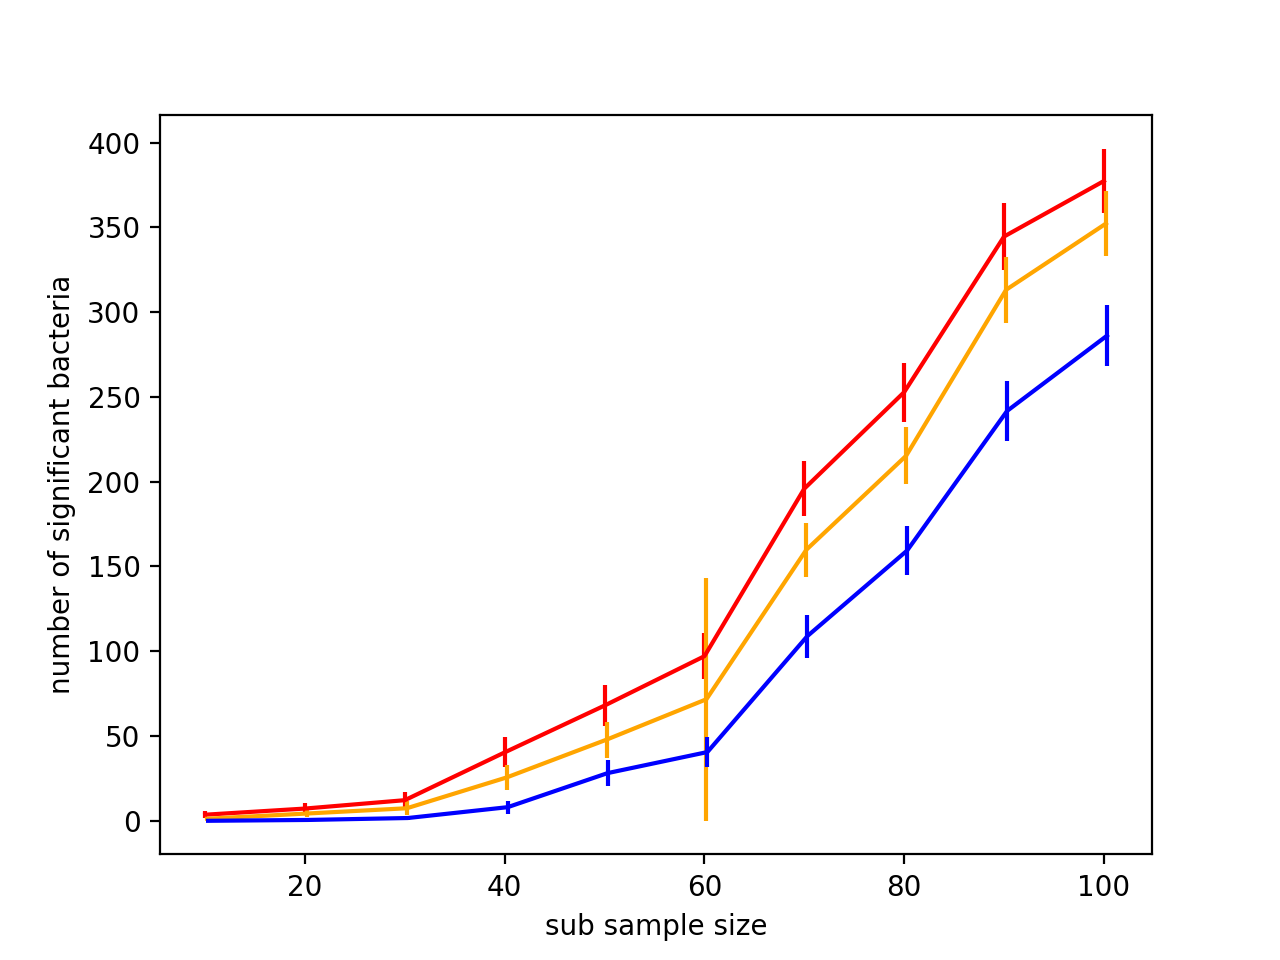

In [53]:
plt.figure()
plt.errorbar(samples, otu_ds, yerr=err_ds, color = 'red')
plt.errorbar(samples+0.2, otu_fbh, yerr=err_fbh, color = 'orange')
plt.errorbar(samples+0.3, otu_bh, yerr=err_bh, color = 'blue')
plt.xlabel('sub sample size')
plt.ylabel('number of significant bacteria')


<IPython.core.display.Javascript object>


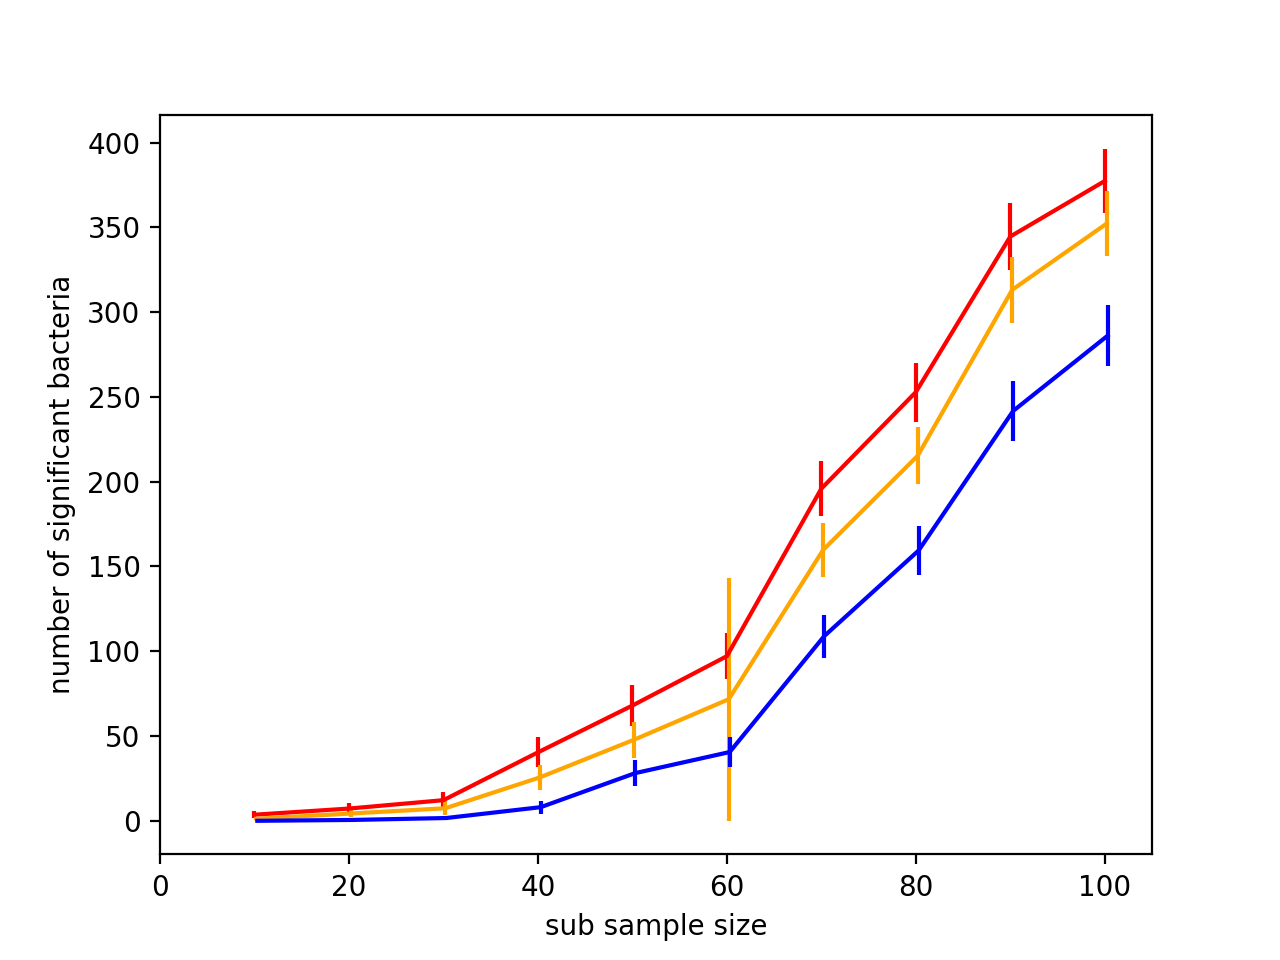

(0, 105)

In [94]:
import pylab 

plt.figure()
plt.errorbar(samples, otu_ds, yerr=err_ds, color = 'red')
plt.errorbar(samples+0.2, otu_fbh, yerr=err_fbh, color = 'orange')
plt.errorbar(samples+0.3, otu_bh, yerr=err_bh, color = 'blue')
plt.xlabel('sub sample size')
plt.ylabel('number of significant bacteria')

pylab.xlim([0, 105])

In [77]:
import pickle
with open("ukt_results.pkl", "wb") as f:
    pickle.dump((otu_ds, otu_bh, otu_fbh, err_ds, err_bh, err_fbh), f)

In [16]:
np.random.seed(31)

B = 100
ss = np.arange(10,110,10)

otu_bh = []
otu_fbh = []
otu_ds = []

err_bh = []
err_fbh = []
err_ds = []

for i in ss:
    print('subsample...: %s' %(i))
    
    ds_num = []
    bh_num = []
    fbh_num = []
    for j in range(B):
        ukt_sub2 = ukt_sub1.downsample('bmi_cat', num_keep=i)
        ds = ukt_sub2.diff_abundance('bmi_cat','Lean','Obese',fdr_method='dsfdr')
        bh = ukt_sub2.diff_abundance('bmi_cat','Lean','Obese',fdr_method='bhfdr')
        fbh = ukt_sub2.diff_abundance('bmi_cat','Lean','Obese',fdr_method='filterBH')

        if ds is None:
            sig_ds = 0
        else:
            sig_ds = len(ds.feature_metadata.index)
        if bh is None:
            sig_bh = 0
        else:
            sig_bh = len(bh.feature_metadata.index)
        if fbh is None:
            sig_fbh = 0
        else:
            sig_fbh = len(fbh.feature_metadata.index)

        ds_num.append(sig_ds)
        bh_num.append(sig_bh)
        fbh_num.append(sig_fbh)
    
    otu_ds.append(np.mean(ds_num))
    otu_bh.append(np.mean(bh_num))
    otu_fbh.append(np.mean(fbh_num))
    
    err_ds.append(sem(ds_num))  
    err_bh.append(sem(bh_num))
    err_fbh.append(sem(fbh_num))

subsample...: 10
subsample...: 20
subsample...: 30
subsample...: 40
subsample...: 50
subsample...: 60
subsample...: 70
subsample...: 80
subsample...: 90
subsample...: 100


<IPython.core.display.Javascript object>


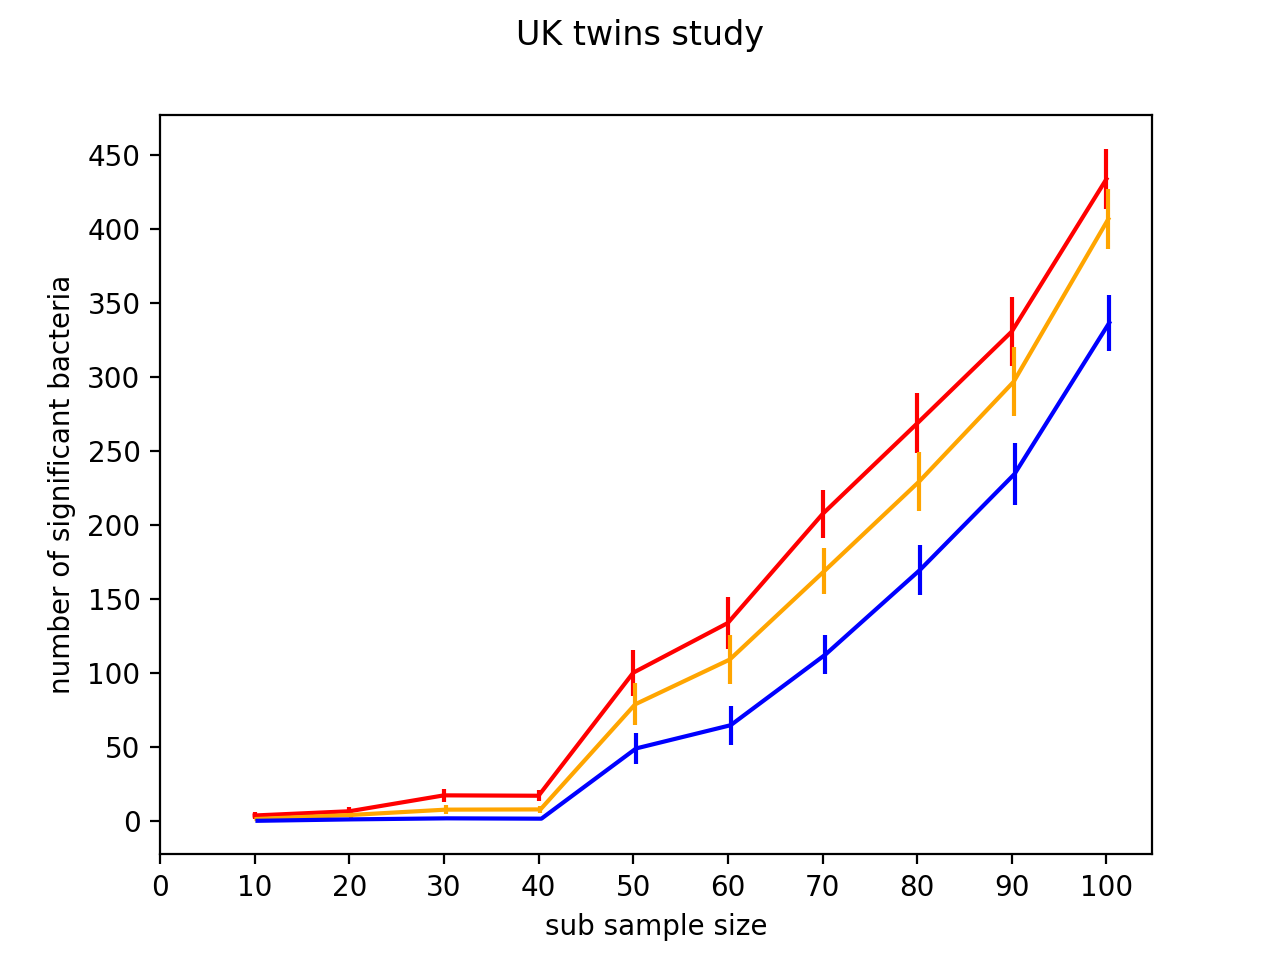

([<matplotlib.axis.XTick at 0x10da2c358>,
 <a list of 11 Text xticklabel objects>)

In [20]:
plt.figure()
plt.errorbar(ss, otu_ds, yerr=err_ds, color = 'red')
plt.errorbar(ss+0.2, otu_fbh, yerr=err_fbh, color = 'orange')
plt.errorbar(ss+0.3, otu_bh, yerr=err_bh, color = 'blue')
plt.suptitle('UK twins study')
plt.xlabel('sub sample size')
plt.ylabel('number of significant bacteria')
plt.yticks(np.arange(0, 500, 50))
plt.xticks(np.arange(0, 110, 10))

In [22]:
import pickle
with open("ukt_subsample.pkl", "wb") as f:
    pickle.dump((ss, otu_ds, otu_bh, otu_fbh, err_ds, err_bh, err_fbh), f)

In [ ]:
with open("ukt_subsample.pkl", "rb") as f:
    ss, otu_ds, otu_bh, otu_fbh, err_ds, err_bh, err_fbh = pickle.load(f)